In [1]:
#Module
import pandas as pd
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

#Methoden
import TFIDFExtraction
import Clean
import AddFeatures
import WordcloudModul
import Plot
import Prediction

#Klassen
from ipynb.fs.full.FahrzeugModell import FahrzeugModell
from ipynb.fs.full.Abbildung import Abbildung

importing Jupyter notebook from TFIDFExtraction.ipynb
importing Jupyter notebook from Clean.ipynb
importing Jupyter notebook from AddFeatures.ipynb
importing Jupyter notebook from WordcloudModul.ipynb
importing Jupyter notebook from Plot.ipynb
importing Jupyter notebook from Prediction.ipynb
importing Jupyter notebook from Preprocessing.ipynb
importing Jupyter notebook from FrequentItemsets.ipynb


## Datensatz

### Fahrzeugmodelle

In [2]:
fahrzeugmodell1 = FahrzeugModell('95BBH1')

fahrzeugmodell2 = FahrzeugModell('95BBL1')

C:\Users\cmato\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,14,16,25,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
big1 = fahrzeugmodell1.get_Big()

big2 = fahrzeugmodell2.get_Big()

### Bearbeiteter Datensatz

In [4]:
big = pd.concat([big1, big2])

big.reset_index(inplace=True, drop=True)

big= big.rename(columns={'support':'Take Rate'})

In [5]:
big.head(3)

,preis_typ_x,gr_prs,waehr_kz_x,option_key,preis,Take Rate,m_familie,Model Year,Model Code,Category,Equipment,Text,Longtext
0,RETAIL,576106.0,CNY,F_AF_0L,29300.0,0.049038,0L,2020,95BBH1,Exterior Colour,0L,Carmine Red,NaN
1,RETAIL,576106.0,CNY,F_AF_0L,29300.0,0.049038,0L,2020,95BBH1,Exterior Colour,0L,Carmine Red,NaN
2,RETAIL,576106.0,CNY,F_VF_0L,0.0,0.049038,0L,2020,95BBH1,Exterior Colour,0L,Carmine Red,NaN


## Generierung von Features

## Explorative Datenanalyse

In [6]:
big_mit_features = AddFeatures.add_features(big)

### Abbildungen

In [7]:
abbildung = Abbildung(big_mit_features)

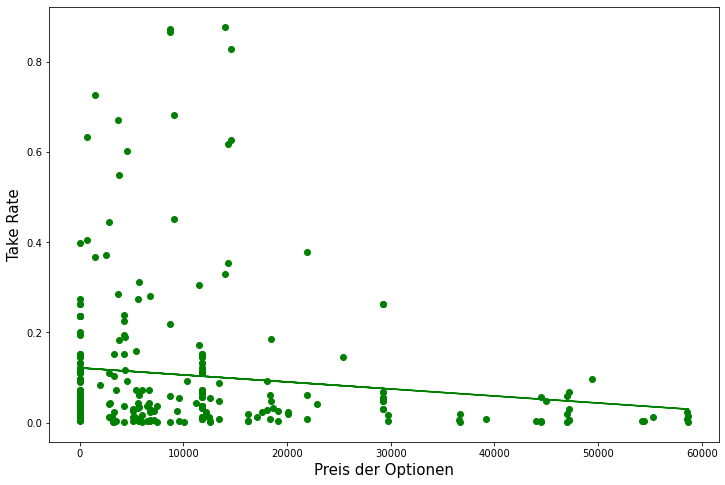

In [8]:
abbildung.plot_preis_take()

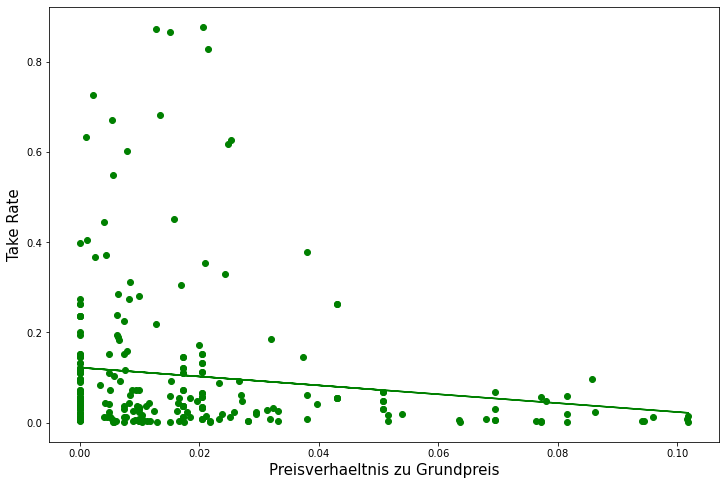

In [9]:
abbildung.plot_grPreis_take()

C:\Users\cmato\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x576 with 0 Axes>

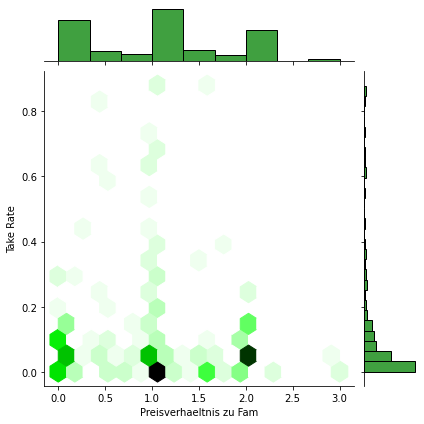

In [10]:
abbildung.plot_Fam_take()

C:\Users\cmato\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 864x576 with 0 Axes>

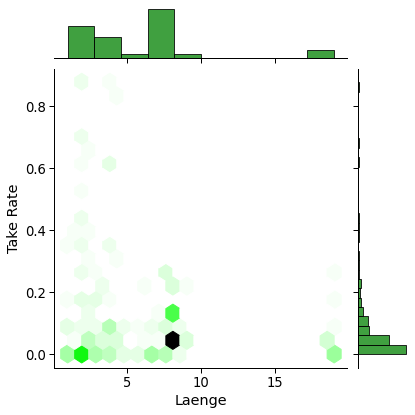

In [11]:
abbildung.plot_Laenge_take()

### Korrelationsmatrix

In [12]:
plt.figure(figsize=(12,8))

corr = big_mit_features.drop('Model Year',
                             axis=1).corr()

corr.style.background_gradient(cmap='Greens')

,gr_prs,preis,Take Rate,Preis_fam-Durchschnitt,Preisverhaeltnis zu Fam,Preisverhaeltnis zu gr_prs,Laenge
gr_prs,1.000000,-0.141864,0.130103,-0.017815,-0.169261,-0.197623,-0.014234
preis,-0.141864,1.000000,-0.135878,0.794335,0.480653,0.995666,0.168952
Take Rate,0.130103,-0.135878,1.000000,-0.081101,-0.051391,-0.143323,-0.191655
Preis_fam-Durchschnitt,-0.017815,0.794335,-0.081101,1.000000,0.000000,0.780554,0.212696
Preisverhaeltnis zu Fam,-0.169261,0.480653,-0.051391,0.000000,1.000000,0.478221,0.000000
Preisverhaeltnis zu gr_prs,-0.197623,0.995666,-0.143323,0.780554,0.478221,1.000000,0.183615
Laenge,-0.014234,0.168952,-0.191655,0.212696,0.000000,0.183615,1.000000


<Figure size 864x576 with 0 Axes>

## Verarbeitung der semantischen Daten

In [13]:
big_nlp = big[['Category','Text','Longtext']]

big_nlp['description'] = big_nlp[big_nlp.columns[:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)

<ipython-input-13-684a63e935f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_nlp['description'] = big_nlp[big_nlp.columns[:]].apply(


In [14]:
clean = lambda x: Clean.clean_text(x)

In [15]:
big_nlp = pd.DataFrame(big_nlp.description.apply(clean))

In [16]:
label = lambda x: TFIDFExtraction.get_kmeans_labels(x)

In [17]:
big_mit_features['themencluster'] = TFIDFExtraction.get_kmeans_labels(big_nlp)

## Wordcloud

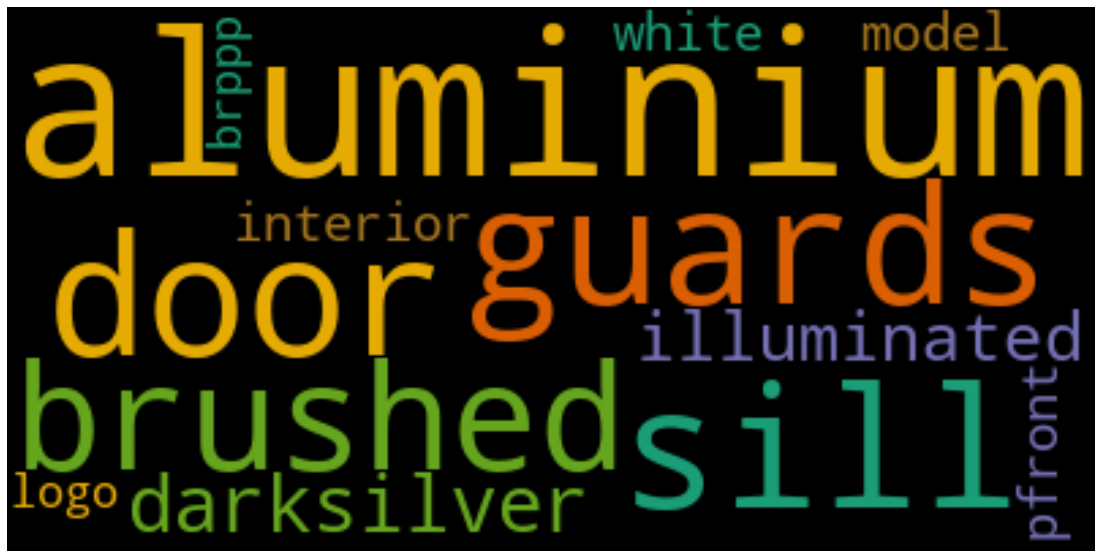

In [18]:
WordcloudModul.show_wordcloud(big_nlp,100)

## Modellierung

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from xgboost import XGBRegressor

### Train-Test Split

In [20]:
x = big_mit_features[['gr_prs', 'preis', 'Preis_fam-Durchschnitt',
                     'Laenge', 'themencluster']]

y = big_mit_features['Take Rate']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3,
                                                    random_state = 42)

In [21]:
x.columns

Index(['gr_prs', 'preis', 'Preis_fam-Durchschnitt', 'Laenge', 'themencluster'], dtype='object')

In [22]:
xgbr = XGBRegressor(max_depth=5, booster ='gbtree',
                    n_estimators=100, random_state=42)

predictor = xgbr.fit(train_x, train_y)

predictions = predictor.predict(test_x)

C:\Users\cmato\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Prognose

### Fehler-Metrik

In [23]:
rmse = mean_squared_error(predictions, test_y, squared=False)

In [24]:
print('RMSE:', round(rmse, 5))

RMSE: 0.15381


## Graphische Abbildung

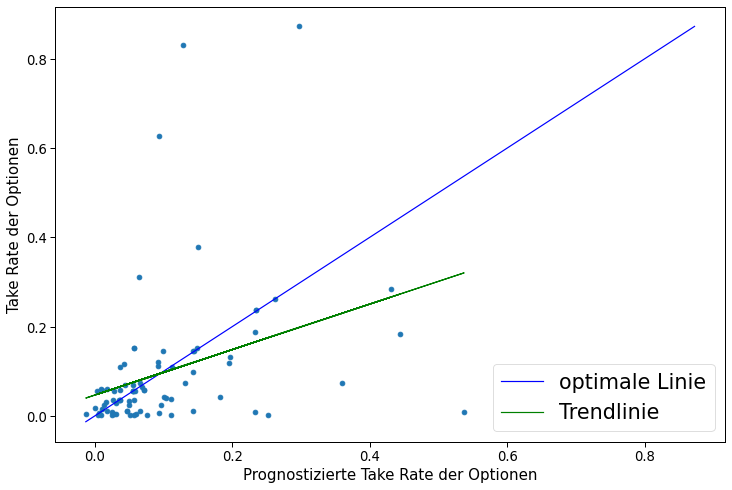

In [25]:
Plot.plt_take(predictions,test_y)

### Datensatz mit Prognose

In [26]:
big_prediction = Prediction.get_result(big, predictions, test_y)

In [27]:
big_prediction.sample(5)

,predictions,test_y,preis_typ_x,gr_prs,waehr_kz_x,option_key,preis,Take Rate,m_familie,Model Year,Model Code,Category,Equipment,Text,Longtext,difference
118,0.017151,0.030488,RETAIL,679646.0,CNY,I_IA_FN,47200.0,0.030488,FN,2020,95BBL1,Interior Colour,FN,GTS leather interior package in Carmine Red (w...,"In Carmine Red: dial of central rev counter, ...",0.013337
160,0.099907,0.146341,RETAIL,679646.0,CNY,F_VF_2Y,0.0,0.146341,2Y,2020,95BBL1,Exterior Colour,2Y,Carrara White Metallic,NaN,0.046435
88,0.009135,0.001442,RETAIL,576106.0,CNY,M_E_VR4,10100.0,0.001442,RAM,2020,95BBH1,Exterior,VR4,SportDesign Sideskirts,Painted in exterior colour: distinctive side s...,0.007692
325,0.430542,0.284615,RETAIL,576106.0,CNY,M_M_9WT,3700.0,0.284615,AUD,2020,95BBH1,Audio / Comm.,9WT,Apple® CarPlay with Siri® voice recognition,To use the apps of your iPhone® even when you...,0.145927
90,0.252702,0.002885,RETAIL,576106.0,CNY,M_E_0PV,5700.0,0.002885,SZU,2020,95BBH1,Exterior,0PV,PORSCHE logo painted in Black (matt) and mod...,In exterior colour or Black (matt): 'PORSCHE' ...,0.249818


## Interpretation des Modells

### Globale Wichtigkeit

In [28]:
import shap

In [29]:
shap_values = shap.TreeExplainer(xgbr).shap_values(test_x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


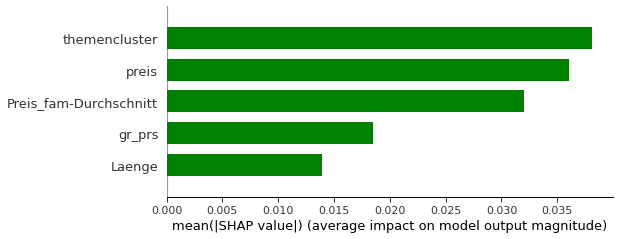

In [30]:
plt.figure(figsize=(20,10))

fig = shap.summary_plot(shap_values, test_x, plot_type="bar",
                        color='green', show= False)

In [31]:
explainer =shap.Explainer(xgbr)
shap_values = explainer(test_x)

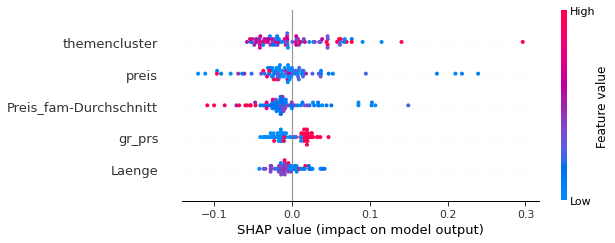

In [32]:
shap.plots.beeswarm(shap_values)

### Lokale Wichtigkeit

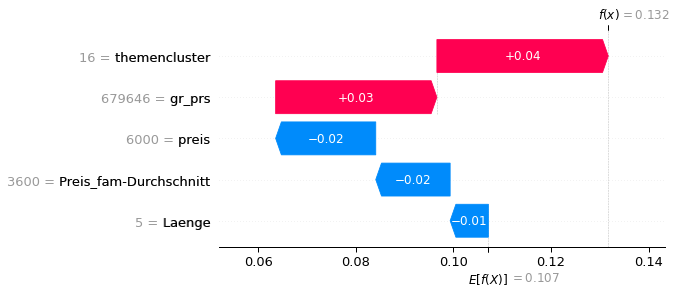

In [33]:
plt.figure(figsize=(12,8))
fig= shap.plots.waterfall(shap_values[10])